# Quantum Computing 
Ahmed Khaled to Dr. Norhan 
<br>
232000046
<br>
Assignment#١


In [1]:
# %pip install "qiskit[visualization]" qiskit-aer qiskit-ibm-provider

In [21]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
# from qiskit_ibm_provider import IBMProvider, least_busy

import matplotlib.pyplot as plt

%matplotlib inline

# Oracles, Constant and Balanced

In [5]:
def constant_oracle(n_input: int, output_value: int) -> QuantumCircuit:
    """
    n_input: number of input qubits (here 3)
    output_value: 0 or 1
    Returns a QuantumCircuit with n_input + 1 qubits implementing a constant oracle.
    """
    qc = QuantumCircuit(n_input + 1, name=f"f_const_{output_value}")
    
    # If f(x) = 1 always, flip the output qubit; if f(x)=0, do nothing.
    if output_value == 1:
        qc.x(n_input)   # last qubit is the ancilla/output
    
    return qc

In [6]:
def balanced_parity_oracle(n_input: int) -> QuantumCircuit:
    """
    Balanced oracle with f(x) = x0 XOR x1 XOR x2 (parity).
    """
    qc = QuantumCircuit(n_input + 1, name="f_bal_parity")
    target = n_input  # ancilla/output
    
    # CNOT from each input to the output – this computes XOR into the target.
    for q in range(n_input):
        qc.cx(q, target)
    
    return qc

In [7]:
n = 3  # number of input qubits

oracle_const0 = constant_oracle(n, 0)
oracle_const1 = constant_oracle(n, 1)
oracle_bal = balanced_parity_oracle(n)

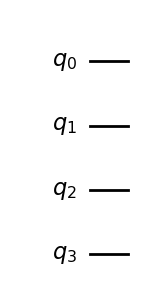

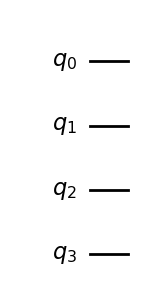

In [8]:
oracle_const0.draw("mpl")

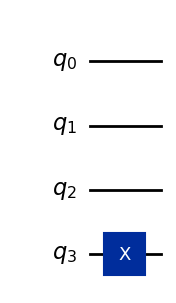

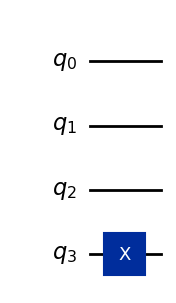

In [9]:
oracle_const1.draw("mpl")


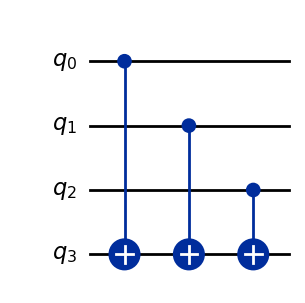

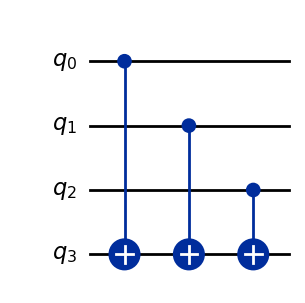

In [10]:
oracle_bal.draw("mpl")

## Deutsch–Jozsa circuit builder

In [12]:
def deutsch_jozsa_circuit(oracle: QuantumCircuit, n_input: int) -> QuantumCircuit:
    """
    Builds the full Deutsch–Jozsa circuit around a given oracle.
    """
    qc = QuantumCircuit(n_input + 1, n_input)

    # 1. Prepare |0...0, 1>  (set ancilla to |1>)
    qc.x(n_input)

    # 2. Hadamards on all qubits
    for q in range(n_input + 1):
        qc.h(q)

    # 3. Apply oracle
    qc.compose(oracle, range(n_input + 1), inplace=True)

    # 4. Hadamards on input register only
    for q in range(n_input):
        qc.h(q)

    # 5. Measure input qubits
    qc.measure(range(n_input), range(n_input))

    return qc


dj_const0 = deutsch_jozsa_circuit(oracle_const0, n)
dj_const1 = deutsch_jozsa_circuit(oracle_const1, n)
dj_bal    = deutsch_jozsa_circuit(oracle_bal, n)

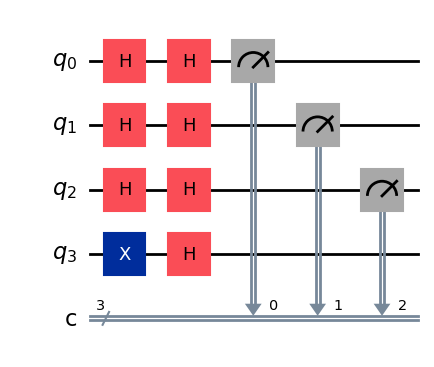

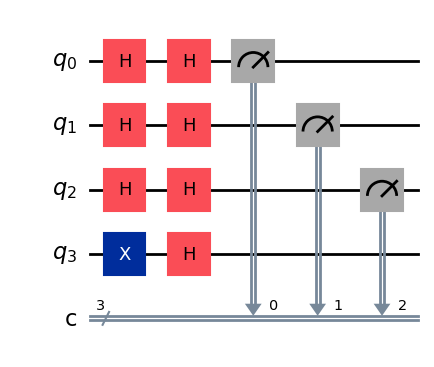

In [13]:
dj_const0.draw("mpl")

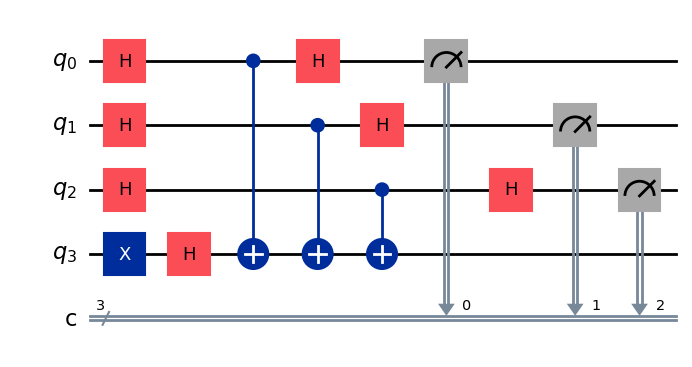

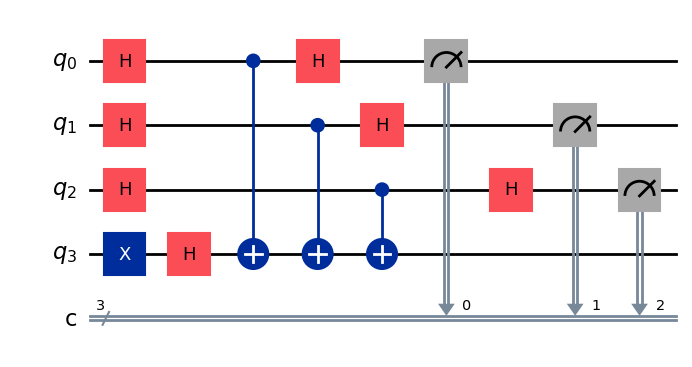

In [14]:
dj_bal.draw("mpl")

## Simulator Running

In [ ]:
sim = AerSimulator()

def run_on_simulator(circuit: QuantumCircuit, shots: int = 1024):
    compiled = transpile(circuit, sim)
    job = sim.run(compiled, shots=shots)
    result = job.result()
    counts = result.get_counts()
    return counts

counts_const0 = run_on_simulator(dj_const0)
counts_const1 = run_on_simulator(dj_const1)
counts_bal    = run_on_simulator(dj_bal)

print("Constant oracle (f(x)=0) counts:", counts_const0)
print("Constant oracle (f(x)=1) counts:", counts_const1)
print("Balanced oracle counts:", counts_bal)

Constant oracle (f(x)=0) counts: {'000': 1024}
Constant oracle (f(x)=1) counts: {'000': 1024}
Balanced oracle counts: {'111': 1024}


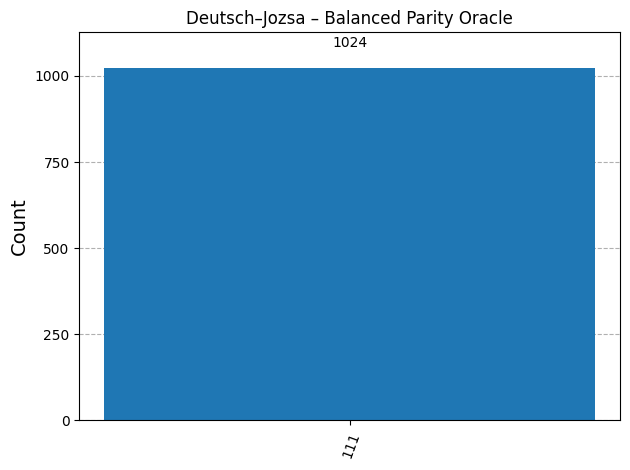

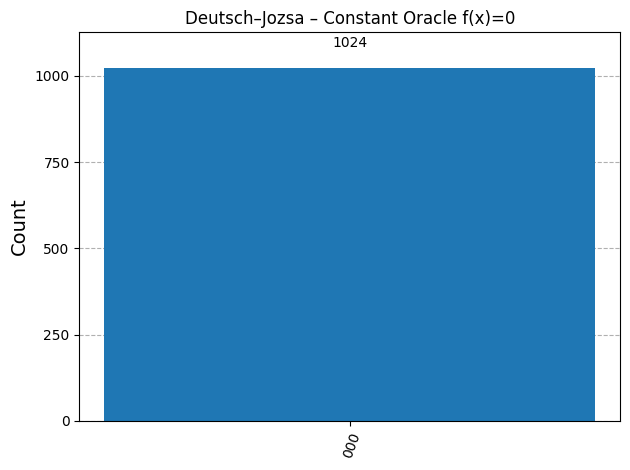

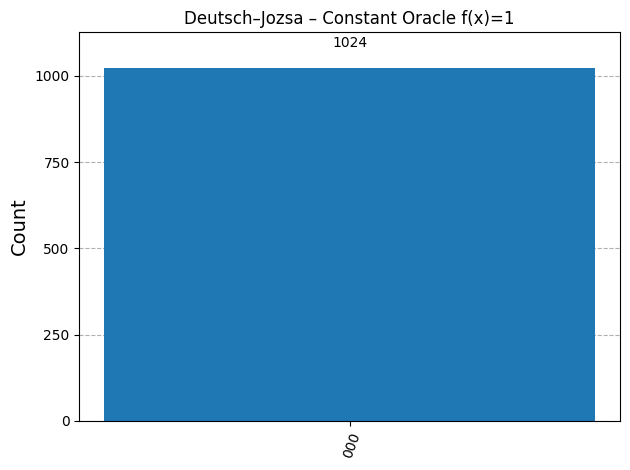

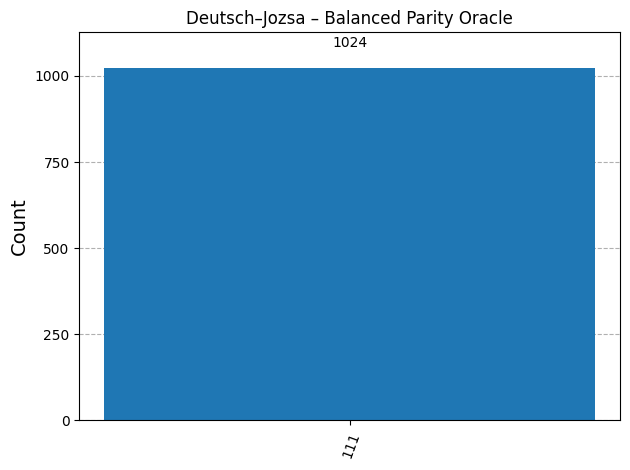

In [ ]:
# Histograms, Mesurements
plot_histogram(counts_const0, title="Deutsch–Jozsa – Constant Oracle f(x)=0")
plot_histogram(counts_const1, title="Deutsch–Jozsa – Constant Oracle f(x)=1")
plot_histogram(counts_bal, title="Deutsch–Jozsa – Balanced Parity Oracle")

## Real Backend Running

In [22]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import matplotlib.pyplot as plt

# g1BxCV5_TSk5aEqUpVFXDZDdc5XQ0halFKGLxq0WXFn2
QiskitRuntimeService.save_account(token="Nyqr-zhd-C3yzhf27NpjWfyVCqmRoSr4LuheZtoBiQHA", overwrite=True)

service = QiskitRuntimeService()

# Select the least busy real quantum computer
backend = service.least_busy(operational=True, simulator=False)
print(f"Selected Backend: {backend.name}")

qiskit_runtime_service.__init__:WARNING:2025-12-07 23:24:48,161: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-12-07 23:24:48,672: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-12-07 23:24:48,672: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-12-07 23:24:51,004: Using instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-12-07 23:24:51,004: Using instance: open-instance, plan: open


Selected Backend: ibm_fez


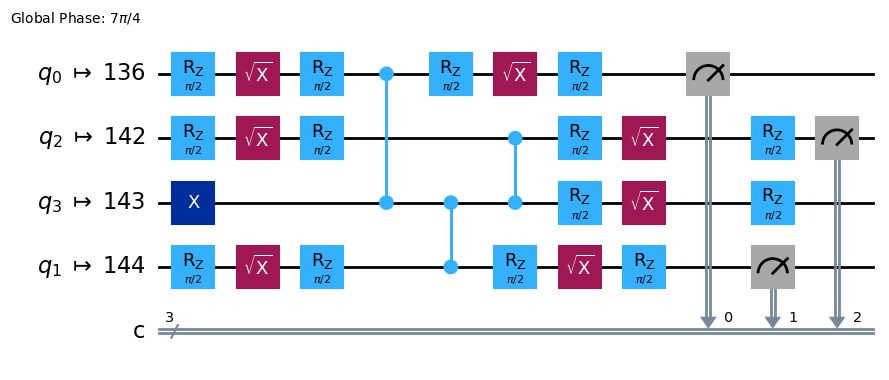

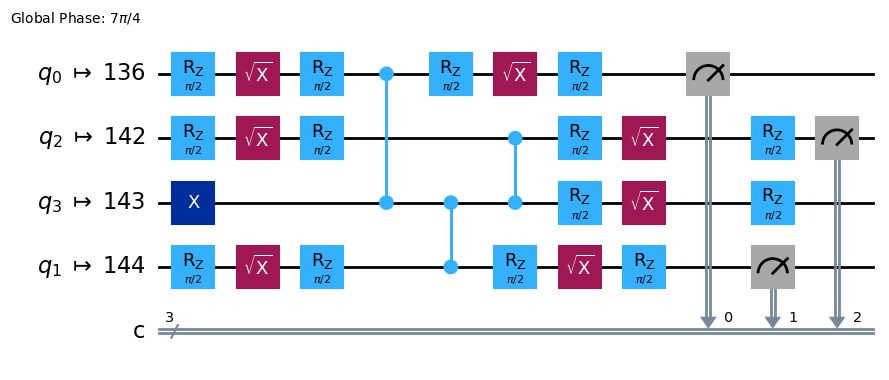

In [23]:
circuit_to_run = dj_bal   # Deutsch–Jozsa circuit with the XOR (parity) oracle

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit_to_run)
isa_circuit.draw("mpl")

In [24]:
print("Submitting job to IBM Quantum...")
sampler = SamplerV2(backend)
job = sampler.run([isa_circuit])
print(f"Job ID: {job.job_id()}")
print(f"Status: {job.status()}")
result_real = job.result()

Submitting job to IBM Quantum...
Job ID: d4qv4rrher1c73bbni10
Job ID: d4qv4rrher1c73bbni10
Status: QUEUED
Status: QUEUED


In [25]:
print(result_real[0].data)

DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=3>))


Real Hardware Counts: {'111': 3910, '110': 57, '101': 43, '011': 64, '001': 8, '000': 10, '100': 3, '010': 1}


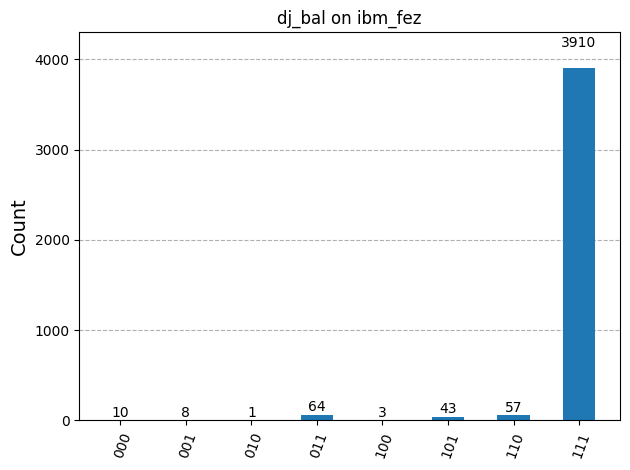

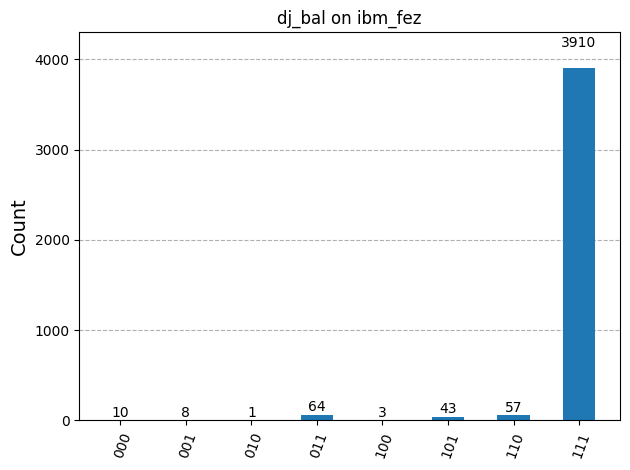

In [27]:
counts_real = result_real[0].data.c.get_counts()
print(f"Real Hardware Counts: {counts_real}")

plot_histogram(counts_real, title=f"dj_bal on {backend.name}")